In [132]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from cmath import e,pi,sin,cos

Simulating Narrowband Sources

Let :

No of Sources = N = 5  
No of Recievers = M = 10  
No of Time Snapshots of Recieved Signal = p = 100   
Frequency of Source = fc = 10^6 Hz   
Sampling Frequency at Sensors = fs = 10^7 Hz   
(=> Time Values for Snapshots are 1/fs, 2/fs, ... , p/fs)    

Source Signal : A * exp(j * 2 * pi * fc * t)     where A ~ Gaussian(0,1)  




In [133]:
N=5
M=10
p=100
fc=1e6
fs=1e7

Generating Source Signals

In [134]:
#Generating Source Signal : Nxp
s = np.zeros((N,p),dtype=complex)
for t in np.arange(start=1,stop=p+1):
    t_val = t/fs
    amp = np.random.multivariate_normal(mean=np.zeros(N),cov=1*np.diag(np.ones(N)))
    s[:,t-1] = np.exp(1j*2*pi*fc*t_val)*amp
print("s=\n",s.shape)

s=
 (5, 100)


Getting the Reciever Signals after Effect of Delay (using Steering Matrix) and Mixing with Noise   

Assume Incident DOAs are 20,50,85,110,145 degrees respectively for the sources, we will find these values using MUSIC algorithm.

Assume signal travels as speed of light = c = 3* 10^8 m/s

Assume Reciever Antenas are spaced at d=150 m in a straight line

In [135]:
#storing DOAs in radians
doa = np.array([20,50,85,110,145])*pi/180

c = 3e8
d = 150

#Steering Vector as a function of theta
def a(theta):
    a1 = np.exp(-1j*2*pi*fc*d*(np.cos(theta)/c) * np.arange(M) )
    return a1.reshape((M,1))
#print(a(2))

A = np.zeros((M,N),dtype=complex)
for i in range(N):
    A[:,i] = a(doa[i])[:,0]

print("A=\n",A.shape)

A=
 (10, 5)


Recieved Signal x(t) = A(theta)*s(t) + n(t), where n(t) is White Gaussian Noise for each reciever

In [136]:
# X1 = np.zeros((p,M),dtype=complex)
# for t in range(p):
#     X1[t] = ( A@(s[t].reshape((N,1))) + np.random.normal(loc=0,scale=1,size=(M,1)) ).reshape((M))
    
# print("X1=\n",X1.shape)

# noise = np.random.normal(loc=0,scale=1,size=(M,1))
noise = np.random.multivariate_normal(mean=np.zeros(M),cov=np.diag(np.ones(M)),size=p).T
X = (A@s + noise)
print("X=\n",X.shape)

X=
 (10, 100)


Application of MUSIC Algorithm:   
    
    When recieved signal data (X), source frequency (fc), no of sources(M), is known, we can find the DOA for each source signal using MUltiple Signal Classification Algorithm. 

In [137]:
#finding covariance matrix of X
S = X@X.conj().T/p

print("emp cov = ",S.shape)

#finding eigen values and eigen vectors
eigvals, eigvecs = np.linalg.eig(S)
eigvals = eigvals.real

#finding norm of eigvals so that they can be sorted in decreasing order
eignorms = np.abs(eigvals)

print("eigvals=",eigvals)

#sorting eig vals and eig vecs in decreasing order of eig vals

idx = eignorms.argsort()[::-1]   
eignorms = eignorms[idx]
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

# idx = eigvals.argsort()[::-1]   
# eignorms = eignorms[idx]
# eigvals = eigvals[idx]
# eigvecs = eigvecs[:,idx]

# print("eigvals=",eigvals)
# print("eigvecs=\n",eigvecs)

print(np.abs(S@eigvecs[:,2]/eigvecs[:,2]))

emp cov =  (10, 10)
eigvals= [18.77030131 14.07047882 12.97927738  8.61692059  7.41672063  0.65688114
  1.26552531  1.11161963  0.90767111  0.95479216]
[12.97927738 12.97927738 12.97927738 12.97927738 12.97927738 12.97927738
 12.97927738 12.97927738 12.97927738 12.97927738]


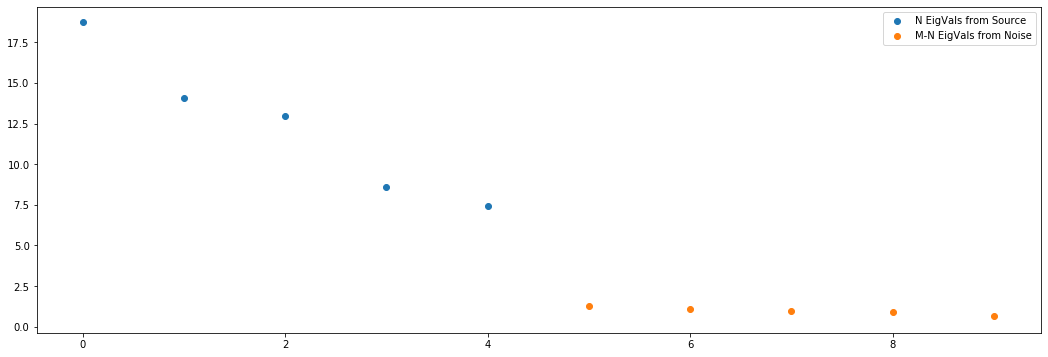

In [138]:
#Plotting Eigen Values

fig, ax = plt.subplots(figsize=(18,6))
ax.scatter(np.arange(N),eigvals[:N],label="N EigVals from Source")
ax.scatter(np.arange(N,M),eigvals[N:],label="M-N EigVals from Noise")
plt.legend()

See that lower M-N eigen values coming due to noise are almost equal (=lb0), and top N eigen values lbi>lb0

In [139]:
#separating source and noise eigvectors
Us, Un = eigvecs[:,:N], eigvecs[:,N:]
print(Us.shape)
print(Un.shape)

(10, 5)
(10, 5)


In [140]:
def P_MU(theta):
#     print(a(theta).conj().T.shape)
#     print(Us.shape)
#     print(np.linalg.norm(a(theta).conj().T@Un))
    return(1/(a(theta).conj().T@Un@Un.conj().T@a(theta)))[0,0]
    
print(P_MU(2))

(0.29931931534524475+3.978686382077704e-17j)


In [144]:
#searching for all possible theta
theta_vals = np.arange(0,181,1)
P_MU_vals = np.array([P_MU(val*pi/180.0) for val in theta_vals]).real
print(P_MU_vals.shape)

print("doas=",doa*180/pi)
print("amps=",amp)

(181,)
doas= [ 20.  50.  85. 110. 145.]
amps= [-0.79240379  0.38473309  2.76491657  1.4693836  -1.2685179 ]


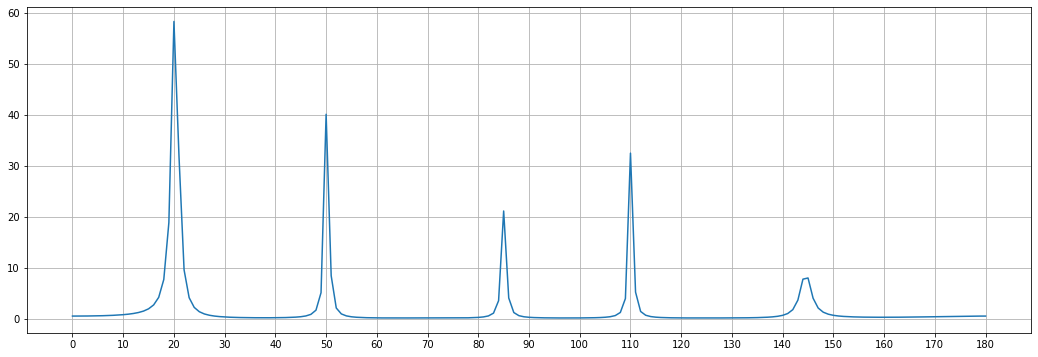

In [145]:
fig, ax = plt.subplots(figsize=(18,6))
plt.plot(np.abs(theta_vals),P_MU_vals)
plt.xticks(np.arange(0, 181, 10))
plt.grid()

In [151]:
peak_indices = scipy.signal.find_peaks_cwt(vector=P_MU_vals, widths = 5*np.ones(len(P_MU_vals)), gap_thresh=None, min_length=None, min_snr=1, noise_perc=10)
print(theta_vals[peak_indices])

[ 21  51  86 111 145 176]
